Para practicar el clustering jerárquico vamos a emplear el dataset  Country-data.csv, que para un conjunto de países incluye información sobre variables relacionadas con la riqueza, como mortalidad infantil, salud, exportaciones, etc.

En principio, sería recomendable preprocesar los datos con un algoritmo de reducción de dimensionalidad, ya que muchas variables están correladas, pero nos vamos a centrar únicamente en dividir los países en grupos acorde al valor original de estas características.

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Descargar el dataset
url = 'https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/Country-data.csv'
df = pd.read_csv(url)
print(df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


Para que todas las columnas sean numéricas pero no tengamos que codificar los nombres de los paises, vamos a pasar la columna country a nombre de las filas (set_index) y eliminarla.

In [2]:
# Establecer el nombre del país como el índice y eliminar la columna de país
df.set_index('country', inplace=True)

Antes de proceder, preescalaremos los datos, ya que algunas columnas son varios órdenes de magnitud mayores que otras, por ejemplo income o gdpp frente a health.

In [3]:
# Escalar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Con los datos preescalados, ya podemos calcular una matriz de distancias usando la métrica que deseemos y usarla para obtener el clustering jerárquico. En este caso usaremos distancia Euclidea, pero podría ser cualquier otra en función de la naturaleza de los datos.

In [4]:
# Calcular la matriz de distancias euclidianas
from scipy.spatial.distance import pdist
dist_mat = pdist(df_scaled, metric='euclidean')

# Realizar el clustering jerárquico
Z = linkage(df_scaled, method='average')

Ahora que ya tenemos el clustering, vamos a representarlo gráficamente, esto es, vamos a dibujar un dendograma. En este tipo de representación se van mostrando las agrupaciones que se efectúan de manera progresiva acorde a la distancia entre los elementos que se agrupan en cada nivel. Por ejemplo, países como Grecia y Portugal o Finlandia y Suecia están muy cercanos, mientras que Malta y Singapur acaban uniéndose ya a una distancia cercana a 4. Evidentemente, los conjuntos de países unidos a bajo nivel pueden agruparse con otros conforme subimos en distancia.

*NOTA: Si no ve las etiquetas en el eje X correctamente, el código guarda el dendograma como imagen en Colab->Files para que pueda ampliarla*

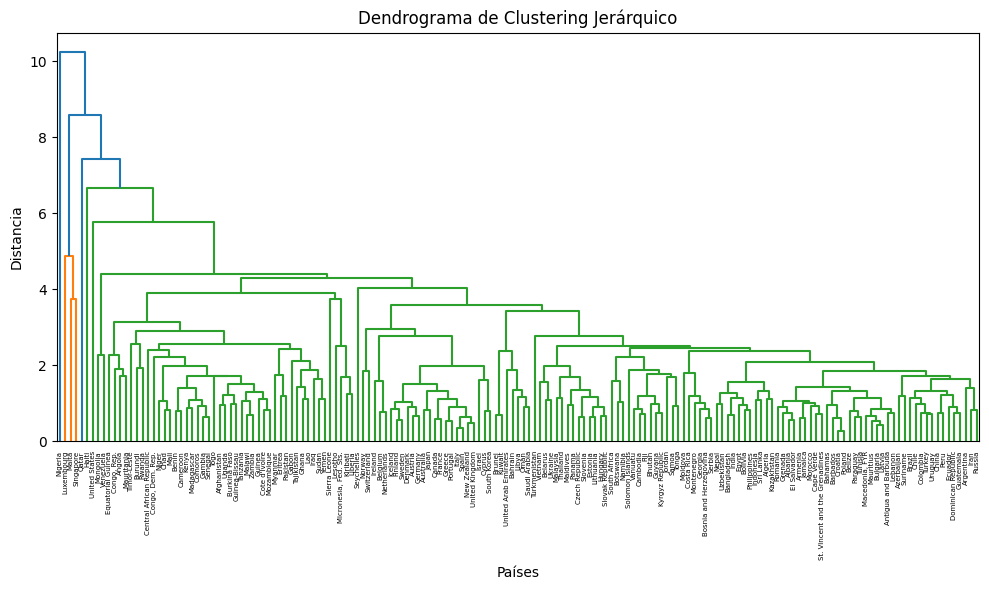

In [5]:
# Dibujar el dendrograma con nombres de países en el eje X
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Países')
plt.ylabel('Distancia')
plt.xticks(rotation=90)  # Girar las etiquetas del eje X en 90 grados
plt.tight_layout()
plt.savefig('dendrograma.png', dpi=300)  # Guardar la figura como una imagen, porque las etiquetas son muy pequeñas
#la imagen salvada está en Files dentro de Colab
plt.show()


Hasta este punto, lo que estamos representando es cómo se organizan los datos de acuerdo a sus distancias, pero aún no se ha concretado el cluster. Para hacerlo, basta con seleccionar el número de clusters deseado (en este ejemplo, 10). La función fcluster nos permite seleccionar el corte de distancia para garantizar dicho número.

También puedo usar como criterio una distancia de corte deseada, por ejemplo, en la figura, 5 (fcluster(Z, distancia_maxima, criterion='distance')),  pero para valores bajos de la misma costaría definir cuantos clusters queremos. Dependiendo de nuestro objetivo, podemos seleccionar el criterio que deseemos.

In [6]:
# Realizar el corte del dendrograma para obtener los clusters
from scipy.cluster.hierarchy import fcluster
k = 10
clusters = fcluster(Z, k, criterion='maxclust')
#distancia_maxima = 5  # Especifica la distancia máxima para el corte del dendrograma
#clusters = fcluster(Z, distancia_maxima, criterion='distance')

Una vez determinamos el punto de corte, se asigna un valor a cada agrupación y, por tanto, a cada elemento, que podemos incorporar al dataframe original.

Además, podemos ver el número de elementos en cada cluster. En la figura resulta obvio que hay uno muy numeroso que agrupa a muchos paises a la derecha del plot y el resto son más pequeños.

In [7]:
# Añadir la información de clusters al DataFrame original
df['Cluster'] = clusters

# Contar los países en cada cluster
print(df['Cluster'].value_counts())

Cluster
5     112
4      45
1       2
3       2
8       1
2       1
10      1
9       1
6       1
7       1
Name: count, dtype: int64


Ahora podemos analizar en detalle qué paises han caido en cada cluster. Hay que recordar que no todos los países del mismo cluster se parecen por igual, esto es, en un proceso jerárquico la cohesión suele ser inferior a uno plano. En este sentido, da más información ver qué países se unieron más tarde o, lo que es lo mismo, los clusters con meos elementos. Por ejemplo, el cluster 1 es Malta/Singapur y el 3 es Mongolia/Venezuela.

In [8]:
# Encontrar qué países han caído en el cluster i
cluster_i_indices = [i for i, cluster in enumerate(clusters) if cluster == 2]
paises_cluster_i = df.index[cluster_i_indices]

# Imprimir los países en el cluster i
print("Países en el cluster i:")
print(paises_cluster_i)


Países en el cluster i:
Index(['Luxembourg'], dtype='object', name='country')


Finalmente, podemos visualizar los resultados del clustering en función de las variables de entrada. Al hacerlo sobre un plano, tendremos que visualizarlas dos a dos.

Por ejemplo, el plot a continuación muestra los clusters en función de la expectativa de vida contra el ingreso. Poco sorprendentemente, países con más ingresos tienen mayor expectativa de vida, aunque se observa cierta estabilización a partir de un umbral.

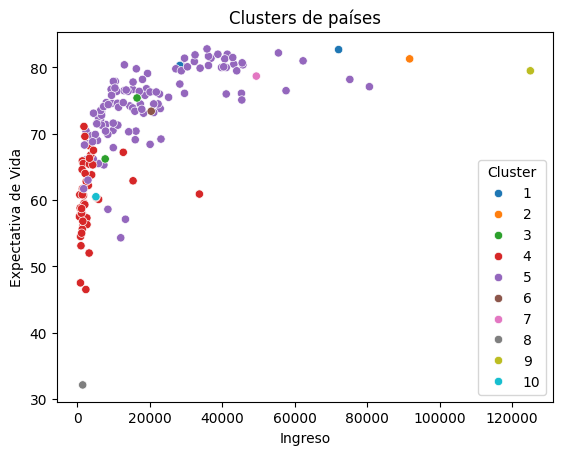

In [9]:
# Visualizar el clustering
import seaborn as sns
sns.scatterplot(x='income', y='life_expec', hue='Cluster', data=df, palette='tab10')
plt.title('Clusters de países')
plt.xlabel('Ingreso')
plt.ylabel('Expectativa de Vida')
plt.show()

Este efecto es aún más acuciado si representamos la mortalidad infantil, que se ceba mayoritariamente con los paises de rentas más bajas.

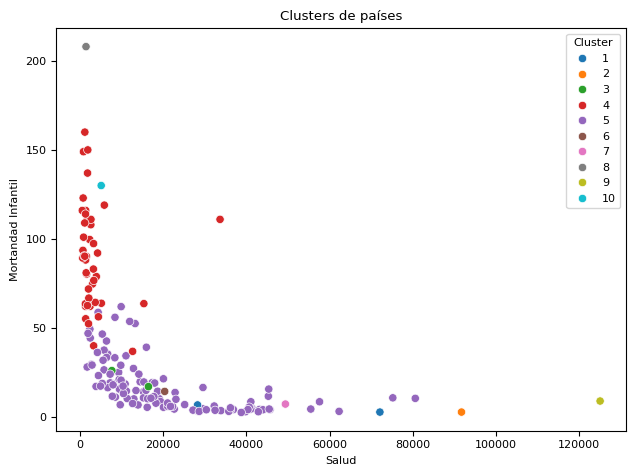

In [ ]:
sns.scatterplot(x='income', y='child_mort', hue='Cluster', data=df, palette='tab10')
plt.title('Clusters de países')
plt.xlabel('Salud')
plt.ylabel('Mortandad Infantil')
plt.show()

Según qué nos interese observar, podemos reorganizar las variables que deseemos en los ejes. Por ejemplo, podemos observar la relación entre GDPP (Producto Interno Bruto (PIB) per cápita) e ingreso. El PIB per cápita representa el valor total de todos los bienes y servicios producidos en el país dividido por la población, mientras que el ingreso per cápita se refiere al ingreso promedio de la población. Si hubiera una distribución ideal, ambos deberían coincidir, esto es, tendríamos una recta con una pendiente de 45 grados.

Una brecha grande donde el ingreso per cápita es mayor que el PIB per cápita podría sugerir que una pequeña parte de la población está capturando la mayor parte de la riqueza generada en el país, mientras que la mayoría de la población recibe ingresos mucho menores en promedio. Esto puede indicar desigualdad económica y social, donde una minoría disfruta de una alta concentración de riqueza mientras que la mayoría enfrenta dificultades económicas y tiene un acceso limitado a recursos y oportunidades.

Se puede comprobar el caso extremo del cluster 9, que incluye a Qatar.

En el otro extremo, si el GDPP es muy superior al ingreso per capita, podría indicar que el país tiene un sistema impositivo progresivo o que las transferencias gubernamentales tienen un impacto significativo en el ingreso disponible de los ciudadanos. Este podría ser el caso del cluster 2, que incluye a Luxemburgo.

NOTA: Tenga en cuenta que hay muchos más factores que influyen en estos análisis, por lo que las conclusiones finales debería extraerlas alguien con coocimiento experto en el área (socioeconomía).

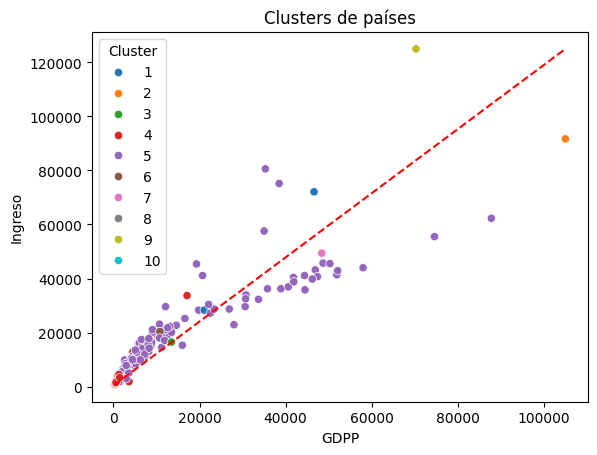

In [10]:
sns.scatterplot(x='gdpp', y='income', hue='Cluster', data=df, palette='tab10')
plt.title('Clusters de países')
plt.xlabel('GDPP')
plt.ylabel('Ingreso')
# Añadir la línea vertical en x=7 en rojo discontinuo
# Añadir la línea x=y en rojo discontinuo
plt.plot([df['gdpp'].min(), df['gdpp'].max()], [df['income'].min(), df['income'].max()], color='red', linestyle='--')

plt.show()